This notebook trains a rfc with all spectral features (band,max,min,diff,avg,entr) for r,g,b,nir and ndvi.


In [ ]:
import os
import time
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from dask_ml.wrappers import ParallelPostFit  # wrapper so that model predicts using dask

from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

from joblib import dump

import model_prep_and_evals as mpe # custom module

In [2]:
# **************************************************************
# whole_set = True => merge train+test sets and train model with combined dataset
# whole_set = False => train model only with train set
whole_set = False
save_model = True
model_name = 'SWE_rfc'

In [9]:
# ------------------------------
# IMPORT TRAIN DATA

root = os.path.join(os.getcwd(), 'data_sampling_workflow')

# select features from red to avg_lidar
# excludes the following features: geometry, aoi, naip_id, polygon_id and iceplant 
X_train = pd.read_csv(os.path.join(root,
                                   'LSWE_train_set.csv')).loc[:,'r':'day_in_year']

# select iceplant feature column
y_train = pd.read_csv(os.path.join(root,
                                   'LSWE_train_set.csv')).loc[:,'iceplant'] 

# remove 2012 and 2014 since these years do not have LIDAR data
X_train = X_train.loc[X_train.year != 2012]
X_train = X_train.loc[X_train.year != 2014]

y_train = y_train.iloc[X_train.index]

# ------------------------------
# IMPORT TEST DATA

# select features from r (Red band) to avg_lidar // excludes geometry, aoi, naip_id, polygon)id and iceplant features
X_test = pd.read_csv(os.path.join(root,
                                  'LSWE_test_set.csv')).loc[:,'r':'day_in_year']

# select iceplant feature column
y_test = pd.read_csv(os.path.join(root,
                                  'LSWE_test_set.csv')).loc[:,'iceplant'] 

# remove 2012 and 2014 since these years do not have LIDAR data
X_test = X_test.loc[X_test.year != 2012]
X_test = X_test.loc[X_test.year != 2014]

y_test = y_test.iloc[X_test.index]

# ------------------------------
if whole_set == True:
    X_train = pd.concat([X_train, X_test], axis = 0)
    y_train = pd.concat([y_train, y_test], axis = 0)

In [10]:
X_train.head()

,r,r_max,r_min,r_diff,r_avg,r_entr,g,g_max,g_min,g_diff,...,nir_entr,ndvi,ndvi_max,ndvi_min,ndvi_diff,ndvi_avg,ndvi_entr,year,month,day_in_year
0,51,67,45,22,55.555557,4.323161,49,63,47,16,...,4.237291,0.471503,0.518717,0.393365,0.125352,0.444444,3.423166,2016,7,195
1,51,77,45,32,58.222220,4.159200,55,83,47,36,...,4.513154,0.442623,0.490385,0.377593,0.112791,0.333333,3.715932,2016,7,195
2,64,68,59,9,63.555557,4.030395,74,79,63,16,...,4.418157,0.407407,0.427184,0.394872,0.032313,0.333333,2.538080,2016,7,195
3,119,119,98,21,107.888885,4.116265,97,97,83,14,...,3.883338,0.105263,0.158333,0.105263,0.053070,0.111111,3.219713,2016,7,195
4,52,55,45,10,51.222220,3.728502,54,60,48,12,...,4.349192,0.350000,0.382022,0.280000,0.102022,0.333333,3.685567,2016,7,195


In [11]:
# ------------------------------
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

In [12]:
t0 = time.time()
rfc = ParallelPostFit(RandomForestClassifier(n_estimators = 100, 
                                             random_state = 42))
rfc.fit(X_train, y_train)
print(time.time() - t0)

if save_model:
    dump(rfc, model_name +'.joblib')


109.91998052597046


In [13]:
if whole_set == False:
    preds = rfc.predict(X_test.to_numpy())
    mpe.print_accuracy_info(y_test.to_numpy(), preds)

true negatives: 100554     false positives: 714
false negatives: 1703     true positives: 53949

sensitivity (TP/P): 96.94 %
specificity (TN/N): 99.29 %
G-mean:  0.98

precision (TP/(TP+FP)): 98.69 %

MCC:  0.966308132252884

F1-measure:  0.97809
F0.5-measure (min false positives):  0.98338
F2-measure (min false negatives)  :  0.97286

accuracy: 98.46 %


In [14]:
result = permutation_importance(
    rfc, 
#    X_test.drop('avg_lidar',  axis = 1,inplace=True),
    X_test.to_numpy(),
    y_test.to_numpy(),
    n_repeats=10, 
    random_state=42, 
    n_jobs=2
)

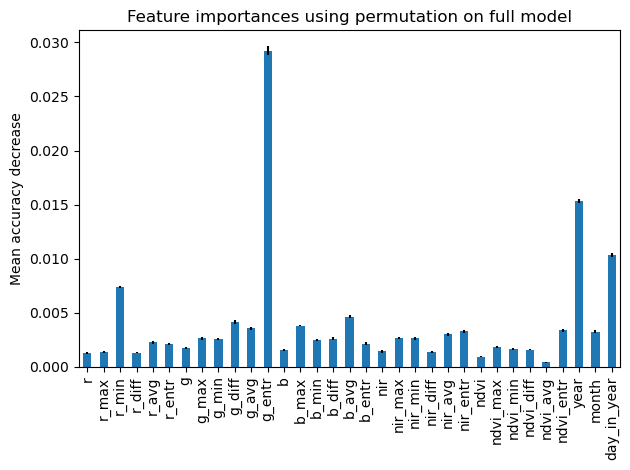

In [15]:
forest_importances = pd.Series(result.importances_mean, index=X_test.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Note:
There are some points in the training and test set that have negative values for min_lidar. 
This is most likely points near the coast where the 3x3 window around the point includes no-data pixels in the canopy height raster.
No-data in the canopy height raster is represented by -999.
However, as a percentage of the points in the total training and test set, these are very few points:

0	275	(non-iceplant with negative min_lidar)
1	559	(iceplant with negative min_lidar)